In [1]:
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt 
from skimage.morphology import skeletonize
from scipy.ndimage.measurements import label

def plane(grid_shape, point, norm):
    point = np.array(point)
    norm = np.array(norm)
    d = -point.dot(norm)
    plane_labelmap = np.zeros(grid_shape)

    if norm[1:].tolist() == [0, 0]:
        plane_labelmap[point[0], :, :] = 1
        return plane_labelmap, None

    if norm[2] == 0:
        xx = list(range(0, grid_shape[0]))
        yy = np.array(point[1] - norm[0] / norm[1] * (xx - point[0]), dtype=int)
        for i in range(len(xx)):
            if yy[i] in range(grid_shape[1]):
                plane_labelmap[xx[i], yy[i], :] = 1
        return plane_labelmap, None

    xx, yy = np.meshgrid(range(grid_shape[0]), range(grid_shape[1]), indexing='ij')


    z = ((-norm[0] * xx - norm[1] * yy - d) /norm[2]).astype(int)

    arr = np.array([[_x, _y, z[_x, _y]] for _x in range(grid_shape[0]) for _y in range(grid_shape[1])])


    for r in arr:
        if r[2] in range(grid_shape[2]):
            plane_labelmap[r[0], r[1], r[2]] = 1
    plane_labelmap = np.round(plane_labelmap).astype(int)
    
    return plane_labelmap, (xx, yy, z)

def enum_directions(a, x, y, z):
    cube = a[x-1:x+2, y-1:y+2, z-1:z+2]
    cube[1,1,1] = 0
    dirs = (np.stack(np.where(cube == 1))-1).T
    res = []
    for d in dirs:
        if (-d).tolist() not in res:
            res.append(d.tolist())
    return np.array(res)

def walk_bound(a, point, direction):
    i = 1
    p = np.array(point)
    d = np.array(direction)
    while True:
        try:
            idx =  p + i * d
            t_val = a[idx[0],idx[1],idx[2]]
            if t_val != 1:
                return idx -  d
            i = i + 1
        except Exception as e:
            return idx - d

def rot_area(n_vox, pixdim, n):
    n = np.array(n)
    n = n / np.linalg.norm(n)
    print(n, np.sin(np.arccos(n[2])), n_vox)
    if list(n) == [0,0,1]:
        return n_vox * pixdim[0] * pixdim[1]
    if list(n) == [0,1,0]:
        return n_vox * pixdim[0] * pixdim[2]
    if list(n) == [1,0,0]:
        return n_vox * pixdim[1] * pixdim[2]
    if n[0] == 0 or n[1] == 0:
        return n_vox * pixdim[0] * pixdim[1] / np.abs(n[2])
    return n_vox * pixdim[0] * pixdim[1] / np.abs(n[2] / n[0] / np.sin(np.arccos(n[2])))

In [2]:
# find vessel and skeleton labelmap
cyl = np.zeros((128,128,128))
for i in range(cyl.shape[2]):
    off = np.sin(i / 128 * 2*np.pi) * 60
    rr, cc = draw.disk((64 + off/5, 64 + off/2), 3, shape=cyl.shape[0:2])
    cyl[rr, cc, i] = 1
vess = cyl
skel = skeletonize(cyl.astype(np.uint8))
# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx][::3]
one[1] = one_pos[1][idx][::3]
one[2] = one_pos[2][idx][::3]
one = np.stack(one)

distances = []
test = []
areas = []
pixdim = [1,1,1]

for i in range(2, one.shape[1]-2):
    # find plane
    normal = ((one[:, i] - one[:, i-2])/2 + (one[:, i] - one[:,i-1]) + (one[:, i+1] - one[:,i]) + (one[:, i+2] - one[:,i])/2)/4
    normal = normal / np.linalg.norm(normal)
    p, t = plane(cyl.shape, one[:, i], normal)
    intersection = p * cyl
    test.append(intersection)
    s = pixdim[0] * np.sqrt(1 + ((pixdim[2]/pixdim[0])**2 - 1)*normal[2])
    areas.append(np.sum(intersection)*pixdim[0]*pixdim[1]*pixdim[2] / s)
    # enum directions
    
    #
    #dirs = enum_directions(intersection, *one[:, i])
    #  
    #dist = []
    #for d in dirs:
    #    p1 = walk_bound(intersection, one[:, i], d)
    #    p2 = walk_bound(intersection, one[:, i], -d)
    #    dist.append(np.linalg.norm(p1 - p2))
    #distances.append((np.mean(dist), np.std(dist)))

print(list(zip(areas, [np.sqrt(a/np.pi) for a in areas])))

[(7.0, 1.4927053303604616), (11.0, 1.8712051592547776), (10.0, 1.7841241161527712), (11.0, 1.8712051592547776), (12.0, 1.9544100476116797), (13.0, 2.0342144725641096), (16.0, 2.256758334191025), (20.0, 2.5231325220201604), (23.0, 2.7057581899030048), (28.0, 2.985410660720923), (25.0, 2.8209479177387813), (26.0, 2.876813695875796), (24.0, 2.763953195770684), (18.0, 2.393653682408596), (15.0, 2.1850968611841584), (12.0, 1.9544100476116797), (11.0, 1.8712051592547776), (11.0, 1.8712051592547776), (10.0, 1.7841241161527712), (10.0, 1.7841241161527712), (9.0, 1.692568750643269), (7.0, 1.4927053303604616), (9.0, 1.692568750643269), (8.0, 1.5957691216057308), (8.0, 1.5957691216057308), (8.0, 1.5957691216057308), (10.0, 1.7841241161527712), (11.0, 1.8712051592547776), (11.0, 1.8712051592547776), (11.0, 1.8712051592547776), (12.0, 1.9544100476116797), (16.0, 2.256758334191025), (19.0, 2.4592453796829674), (24.0, 2.763953195770684), (26.0, 2.876813695875796), (25.0, 2.8209479177387813), (26.0, 2

In [1]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# vessel
pos = np.where(cyl==1)
ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.01)

# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx]
one[1] = one_pos[1][idx]
one[2] = one_pos[2][idx]
one = np.stack(one)
ax.plot(one[0], one[1], one[2], c='black')

ax.set_xlim(0, cyl.shape[0])
ax.set_ylim(0, cyl.shape[1])
ax.set_zlim(0, cyl.shape[2])

el = 5
p_reg = np.where(test[el] == 1)
ax.scatter(p_reg[0], p_reg[1], p_reg[2], alpha=1, c='black')

plt.show()


print(np.pi * 3 **2)

NameError: name 'plt' is not defined

In [438]:
import nibabel as nib

sk = nib.load('../data/multiskel_vess.nii.gz').get_fdata()

skel = (sk == 1.0).astype(int)

tub = nib.load('../data/multilab_vess.nii.gz').get_fdata()

vess = (tub == 1.0).astype(int)

KeyboardInterrupt: 

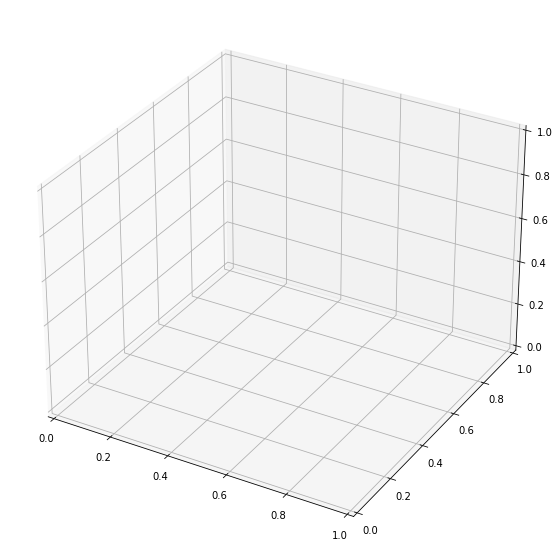

In [442]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

pos = np.where(skel == 1)
ax.scatter(pos[0], pos[1], pos[2], c='black', alpha=1, s=0.5)
pos_vess = np.where(vess == 1)
ax.scatter(pos_vess[0], pos_vess[1], pos_vess[2], c='red', alpha=0.1, s=1)
plt.show()

bb = np.empty(shape=(3, 2), dtype=int)
for i in range(3):
    bb[i, 0] = min(np.min(pos[i]), np.min(pos_vess[i]))
    bb[i, 1] = max(np.max(pos[i]), np.max(pos_vess[i]))


skeleton = skel[bb[0, 0]:bb[0, 1]+1, bb[1, 0]:bb[1, 1]+1, bb[2, 0]:bb[2, 1] +1]
vessel = vess[bb[0, 0]:bb[0, 1]+1, bb[1, 0]:bb[1, 1]+1, bb[2, 0]:bb[2, 1] +1]

In [423]:
IMG_DIM = skeleton.shape
PIXDIM = [1,1,1]

test = []
l = []
pos = np.where(skeleton == 1)
for i in range(len(pos[0])):
    cube = skeleton[pos[0][i]-1:pos[0][i]+2, pos[1][i]-1:pos[1][i]+2, pos[2][i]-1:pos[2][i]+2]
    l.append(np.sum(cube))

idxs = [i for i, d in enumerate(l) if d == 3]
planes = []
areas = []
points = []
for i, idx in enumerate(idxs):
    x = pos[0][idx]
    y = pos[1][idx]
    z = pos[2][idx]
    cube = skeleton[x-1:x+2, y-1:y+2, z-1:z+2]
    pts = np.stack(np.where(cube == 1)).T
    o = np.array([x,y,z])
    pts = [pts[j] - np.array([1,1,1]) for j in range(pts.shape[0]) if pts[j].tolist() != [1,1,1]]

    normal = pts[0] - pts[1]
    normal = normal / np.linalg.norm(normal)
    
    p, t = plane(IMG_DIM, o, normal)
    test.append(t)
    intersection = p * vessel
    planes.append(intersection)
    if(np.sum(intersection) == 0):
        print(normal)
    s = PIXDIM[0] * np.sqrt(1 + ((PIXDIM[2]/PIXDIM[0])**2 - 1)*normal[2])
    areas.append(np.sum(intersection)*PIXDIM[0]*PIXDIM[1]*PIXDIM[2] / s)
    points.append(o)

[11 10 49] 5


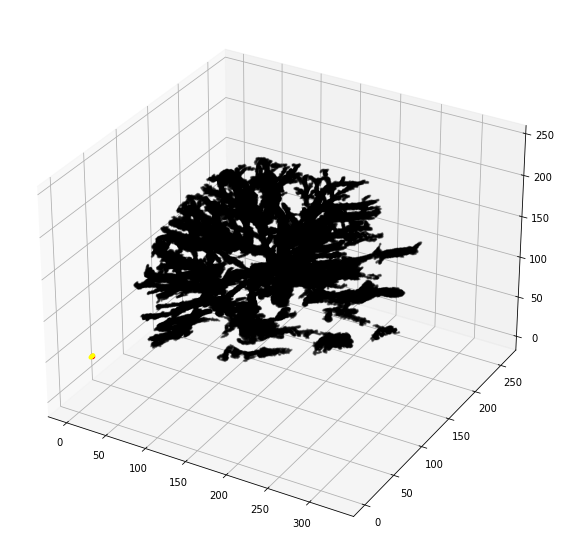

In [441]:
el = 10

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

pos = np.where(vessel == 1)
ax.scatter(pos[0], pos[1], pos[2], c='black', alpha=0.2, s=1.5)

struct = np.ones(shape=(3,3,3))
labeled, _ = label(planes[el], structure=struct)

lab = labeled[points[el][0], points[el][1], points[el][2]]
if lab != 0:
    pos_vess = np.where(labeled == lab)
    ax.scatter(pos_vess[0], pos_vess[1], pos_vess[2], c='yellow', alpha=1, s=10)
    print(points[el], len(pos_vess[0]))

ax.scatter(*points[el], c='red', s=20)
#ax.plot_surface(test[el][0], test[el][1], test[el][2], alpha=0.5)
plt.show()

In [434]:
areas

[10.0,
 8.0,
 10.0,
 28.0,
 51.0,
 148.0,
 15.0,
 19.0,
 159.0,
 24.0,
 15.0,
 53.0,
 47.0,
 58.0,
 19.0,
 152.0,
 91.0,
 26.0,
 102.0,
 22.0,
 53.0,
 61.0,
 15.0,
 58.0,
 61.0,
 17.0,
 125.0,
 23.0,
 97.0,
 11.0,
 62.0,
 15.0,
 36.0,
 67.0,
 21.0,
 189.0,
 9.0,
 33.0,
 10.0,
 9.0,
 8.0,
 11.0,
 9.0,
 4.0,
 5.0,
 9.0,
 34.0,
 115.0,
 16.0,
 32.0,
 44.0,
 128.0,
 40.0,
 47.0,
 25.0,
 35.0,
 8.0,
 124.0,
 49.0,
 50.0,
 8.0,
 115.0,
 35.0,
 76.0,
 61.0,
 52.0,
 83.0,
 52.0,
 40.0,
 63.0,
 47.0,
 50.0,
 39.0,
 80.0,
 100.0,
 19.0,
 102.0,
 57.0,
 49.0,
 49.0,
 112.0,
 21.0,
 66.0,
 49.0,
 44.0,
 34.0,
 23.0,
 10.0,
 45.0,
 26.0,
 115.0,
 50.0,
 44.0,
 44.0,
 45.0,
 40.0,
 125.0,
 130.0,
 130.0,
 96.0,
 162.0,
 45.0,
 146.0,
 68.0,
 33.0,
 62.0,
 144.0,
 34.0,
 110.0,
 42.0,
 31.0,
 42.0,
 56.0,
 59.0,
 23.0,
 29.0,
 18.0,
 26.0,
 165.0,
 84.0,
 50.0,
 29.0,
 56.0,
 8.0,
 122.0,
 34.0,
 137.0,
 81.0,
 50.0,
 112.0,
 56.0,
 124.0,
 86.0,
 33.0,
 87.0,
 25.0,
 16.0,
 78.0,
 29.0,
 118.0,
 121